# CH_06_3_Model Training using Minibatch

- Last update : 2022.04.01.

## Previous Chapter methods : 
>### # SingleLayer
>### # DoubleLayer
>### # RandomInitNetwork

In [1]:
##=============================================================
# Sample Dataset 
##=============================================================
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split 

cancer = load_breast_cancer( )
x = cancer.data 
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                           test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify= y_train_all, 
                                                  test_size=0.2, random_state=42)
# Verification of training set size and verification set size 
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [2]:
##=============================================================
## Preprocessing training data standardization
##=============================================================
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()                # transform dataset into m=0 std=1
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)


print (">>> x_train_scaled =\n", x_train_scaled)
print("=============================================================================")
print (">>> x_val_scaled =\n", x_val_scaled)

>>> x_train_scaled =
 [[ 0.21529445 -0.3313719   0.17983103 ... -0.48870759  1.0446075
  -0.6393202 ]
 [-0.6557398  -1.14919128 -0.71043609 ... -0.49139007  0.27379602
  -0.9632616 ]
 [ 0.18967579  0.55160342  0.16625487 ...  1.00632788  1.19598931
   1.3439391 ]
 ...
 [ 0.11281983 -0.88856752  0.10125385 ...  0.65611522 -0.35953605
  -0.42335927]
 [ 0.96108195  1.44356576  0.94585569 ... -0.08901809 -2.0401831
  -0.8927216 ]
 [-0.74398184 -0.41000838 -0.73429722 ... -0.77275241 -0.52482027
  -0.19925911]]
>>> x_val_scaled =
 [[-0.80945173  2.29958    -0.85730548 ... -1.7268211  -2.09733746
  -1.38812946]
 [ 0.89845857  1.20990308  0.93351373 ...  1.10319521  0.60127505
   2.67334684]
 [ 1.14895208  0.60777233  1.06516136 ... -0.35860732 -0.85693343
  -1.0338016 ]
 ...
 [-0.65004677  0.55385017 -0.69068894 ... -1.17318705 -0.75807184
  -1.03108852]
 [-0.51056743 -0.26846272 -0.54464235 ... -0.50316318  0.29233257
  -0.17972496]
 [ 0.75328619  0.23930426  0.64142054 ... -0.42477516  2.7

## SingleLayer Method class 

In [3]:
##=============================================================
# SingleLayer Method class 
##=============================================================

class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None                   # weight  
        self.b = None                   # interscept 
        self.losses = []                # training loss 
        self.val_losses = []            # verification loss 
        self.w_history = []             # weight records 
        self.lr = learning_rate         # learning rate  
        self.l1 = l1                    # L1 loss hyperparameter 
        self.l2 = l2                    # L2 loss hyperparameter 
        
    def forpass(self, x): 
        z = np.dot(x, self.w) + self.b      # linear output calculation 
        return z 
    
    def backprop(self, x, err): 
        m = len(x)
        w_grad = np.dot(x.T, err) / m       # Gradient Calculation on weight 
        b_grad = np.sum(err) / m            # Gradient Calculation on intercept
        return w_grad, b_grad 
    
    def activation(self, z): 
        z = np.clip(z, -100, None)          # for safe np.exp() calculation 
        a = 1/(1 + np.exp(-z))              # Sigmoid calculation 
        return a 
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)                              # Change the target as column vector 
        y_val = y_val.reshape(-1, 1)                      # Change the verification target as column vector
        m = len(x)                                        # Save the no. of sample 
        self.w = np.ones((x.shape[1], 1))                 # Initialize the weight  
        self.b = 0                                        # Initialize the interscept 
        self.w_history.append(self.w.copy( ))             # Record the weight 
        # repeat routine epochs times 
        for i in range(epochs): 
            z = self.forpass(x)                            # Implement Forward propagation Calculation 
            a = self.activation(z)                         # Apply activation function 
            err = -(y - a)                                 # Calculate error 
            # Calculating Gradient by error backpropagation 
            w_grad, b_grad = self.backprop(x, err)
            # Add differentiation of pannelty in Gradient 
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m 
            # updating weight and interscept 
            self.w -= self.lr * w_grad 
            self.b -= self.lr * b_grad 
            # recording weight 
            self.w_history.append(self.w.copy( ))
            # Clipping for safe log calculation 
            a = np.clip(a, 1e-10, 1-1e-10)
            # adding log loss and rule loss and adding it to the list
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss( )) / m)
            # calculating loss on verification set 
            self.update_val_loss(x_val, y_val)
            
    def predict(self, x): 
        z = self.forpass(x)                 # Implement forward propagation Calculation 
        return z > 0                        # Apply Step function 

    def score(self, x, y): 
        # return True ratio by comparing prediction and Target column vector 
        return np.mean(self.predict(x) == y.reshape(-1, 1))

    def reg_loss(self): 
        # Apply Regularization on weight 
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

    def update_val_loss(self, x_val, y_val): 
        z = self.forpass(x_val)             # Implement forward propagation Calculation 
        a = self.activation(z)              # Implenent activation function 
        a = np.clip(a, 1e-10, 1-1e-10)      # Clipping output 
        # merging log loss with Regularization loss and adding it to the list
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

## Dual layer Neural Network

In [4]:
##=============================================================
# 1. Generating DualLayer class being inherited from SingleLayer class 
#----------------------------------------------------------------------
class DualLayer(SingleLayer): 
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units                 # No. of Neuron in hidden layer 
        self.w1 = None                     # wight of hidden layer 
        self.b1 = None                     # intercept of hidden layer 
        self.w2 = None                     # weight of output layer 
        self.b2 = None                     # intercept of output layer  
        self.a1 = None                     # activation output of hidden layer 
        self.losses = []                   # training loss 
        self.val_losses = []               # varifying loss 
        self.lr = learning_rate            # learning rate 
        self.l1 = l1                       # L1 loss Hyperparamter
        self.l2 = l2                       # L2 loss Hyperparamter
    #---------------------------------------------
    # 2. Modifying forpass() method 
    #---------------------------------------------
    def forpass(self, x): 
        z1 = np.dot(x, self.w1) + self.b1            # Calculating linear regression of first layer
        self.a1 = self.activation(z1)                # Applying Activation Function 
        z2 = np.dot(self.a1, self.w2) + self.b2      # Calculating linear regression of second layer
        return z2 

    #---------------------------------------------
    # 3. Modifying backprop() method
    #---------------------------------------------
    def backprop(self, x, err): 
        m = len(x)                 # no. of sample 
        # Calculating Gradient on weight and intercept in output layer 
        w2_grad = np.dot(self.a1.T, err) / m 
        b2_grad = np.sum(err) / m 
        # Calculating Gradient in sigmoid function 
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # Calculating Gradient on weight and intercept in hidden layer
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m 
        return w1_grad, b1_grad, w2_grad, b2_grad

    #---------------------------------------------
    # 4. Modifying fit() method (1)
    #---------------------------------------------
    # 5. weight initializing part : init_weights(self, n_features) 
    #---------------------------------------------
    def init_weights(self, n_features): 
        self.w1 = np.ones((n_features, self.units))      # (no. of features, size of hidden layer)
        self.b1 = np.zeros(self.units)                   # size of hidden layer
        self.w2 = np.ones((self.units, 1))               # (size of hidden layer, 1)
        self.b2 = 0 

    #---------------------------------------------
    # 6. training method separation in for() block
    #---------------------------------------------
    def fit(self, x, y, epochs=100, x_val=None, y_val=None): 
        y = y.reshape(-1, 1)                  # change the target as column vector
        y_val = y_val.reshape(-1, 1)                      
        m = len(x)                            # saving the no. of sample 
        self.init_weights(x.shape[1])         # initializing weights of hidden layer and output layer
        # repeat routine epochs times 
        for i in range(epochs): 
            a = self.training(x, y, m)
            # clipping data for safe log calculation 
            a = np.clip(a, 1e-10, 1-1e-10)
            # merging log loss into Regularatory loss and adding it to the list 
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # Calculating loss for verification set 
            self.update_val_loss(x_val, y_val)

    def training(self, x, y, m): 
        z = self.forpass(x)                # Implementing forward propagation calculation 
        a = self.activation(z)             # Applying activation function 
        err = -(y - a)                     # Caculating errors 
        # Caculating Gradient by backpropagating errors
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # Eliminating differentiation in penalty in Gradient 
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m 
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m 
        # updating weight and interscept in hidden layer 
        self.w1 -= self.lr * w1_grad 
        self.b1 -= self.lr * b1_grad 
        # updating weight and interscept in output layer 
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad 
        return a   

    #---------------------------------------------
    # 7. Modifying reg_loss() method 
    #---------------------------------------------
    def reg_loss(self): 
        # applying Regulatory on weight of hidden layer and outpur layer 
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))



##=============================================================
## Improving weight initialization
##=============================================================
# 1. Modifying init_weights() method for weight initialization
##=============================================================
class RandomInitNetwork(DualLayer):
    
    def init_weights(self, n_features):
        np.random.seed(42)
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))   # (no. of features, size of hidden layer)
        self.b1 = np.zeros(self.units)                         # size of hidden layer
        self.w2 = np.random.normal(0, 1, (self.units, 1))      # (size of hidden layer, 1) 
        self.b2 = 0

## 1. Implementing Minibatch Gradient descent 

In [5]:
##===============================================
# 1.1. Generating MinibatchNetwork Class
##===============================================
class MinibatchNetwork(RandomInitNetwork): 
  
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        super( ).__init__(units, learning_rate, l1, l2)
        self.batch_size = batch_size       # batch size 

    ##===============================================
    # 1.2. Modifying fit() Method
    ##===============================================
    def fit(self, x, y, epochs=100, x_val=None, y_val=None): 
        y_val = y_val.reshape(-1, 1)             # change the target into column vector
        self.init_weights(x.shape[1])            # Initializing the weights of hidden layer and outpur layer 
        np.random.seed(42)

        # repeat the routine epoch times 
        for i in range(epochs):
            loss = 0
            # Circulating minibatch returned from generator function 
            for x_batch, y_batch in self.gen_batch(x, y):
                y_batch = y_batch.reshape(-1, 1)             # change the target into column vector
                m = len(x_batch)                             # savting the no. of samples
                a = self.training(x_batch, y_batch, m)
                # Clipping variable for safe log calculation 
                a = np.clip(a, 1e-10, 1-1e-10)
                # Merging log loss with Regularization loss and adding it to the list 
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss( )) / len(x))
            # Calculate the loss of verification set 
            self.update_val_loss(x_val, y_val)

    ##===============================================
    # 1.3. Generating gen_batch() Method
    ##===============================================
    # minibatch generator function 
    def gen_batch(self, x, y): 
        length = len(x)
        bins = length // self.batch_size            # minibatch frequency 
        if length % self.batch_size: 
            bins += 1                               # if it has a remainder...    
        indexes = np.random.permutation(np.arange(len(x)))      # shuffling the indices 
        x = x[indexes]
        y = y[indexes]
        for i in range(bins): 
            start = self.batch_size * i 
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]        # returning the variables slicing in batch_size length

## Sample Dataset & Preprocessing training data standardization

In [6]:
# 1.4. Implementing Minibatch Gradient descent 

minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)
print (">>> Score : ", minibatch_net.score(x_val_scaled, y_val))

>>> Score :  0.978021978021978


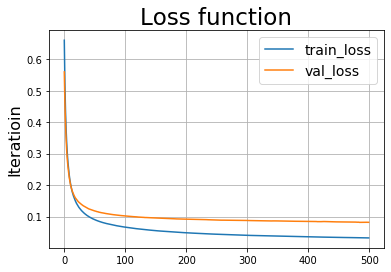

In [7]:
# plot the graph 
fig, ax1 = plt.subplots()

ax1.plot(minibatch_net.losses)
ax1.plot(minibatch_net.val_losses)

ax1.set_title('Loss function', fontsize = '23')
ax1.set_ylabel('loss', fontsize = '16')
ax1.set_ylabel('Iteratioin', fontsize = '16')

ax1.legend(['train_loss', 'val_loss'], fontsize = '14')

ax1.grid( )
plt.show( )

In [8]:
# 1.5. Retrial after resizing 

minibatch_net2 = MinibatchNetwork(l2=0.01, batch_size=128)
minibatch_net2.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net2.score(x_val_scaled, y_val)
print (">>> Score : ", minibatch_net2.score(x_val_scaled, y_val))

>>> Score :  0.978021978021978


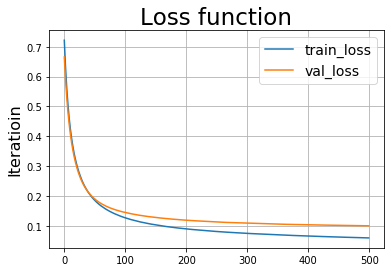

In [13]:
# plot the graph 
fig, ax2 = plt.subplots()

ax2.plot(minibatch_net2.losses)
ax2.plot(minibatch_net2.val_losses)

ax2.set_title('Loss function', fontsize = '23')
ax2.set_ylabel('loss', fontsize = '16')
ax2.set_ylabel('Iteratioin', fontsize = '16')

ax2.legend(['train_loss', 'val_loss'], fontsize = '14')

ax2.grid( )
plt.show( )

## 2. Training MultiLayer Neural Network using sklearn 

In [10]:
# 2.1. Generating the Object of MLPClassifier 

from sklearn.neural_network import MLPClassifier 
mlp = MLPClassifier(hidden_layer_sizes = (10, ), activation = 'logistic', 
                    solver='sgd', alpha=0.01, batch_size=32, 
                    learning_rate_init=0.1, max_iter=500)

In [11]:
# 2.2. Training Model 

mlp.fit(x_train_scaled, y_train)
print (">>> Score : ", mlp.score(x_val_scaled, y_val))

>>> Score :  0.989010989010989
